In this notebook, I implemented the REINFORCE algorithm both with and without a baseline and then compared their performance. The target is the total return of the episode, as the REINFORCE algorithm is considered a Monte Carlo method. Additionally, for updating the objective, I used an online method instead of batch training, updating the objective after each episode.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import gym
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(state_dim, action_dim)

    def forward(self, x):
        x = self.fc(x)
        return nn.functional.softmax(x, dim=-1)

    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert to tensor and add batch dimension
        probs = self.forward(state)
        action = torch.multinomial(probs, num_samples=1).item()
        action_prob = probs[0, action]  # Get the probability of the selected action
        log_action_prob = torch.log(action_prob)  # Get the log probability of the action
        return action, action_prob, log_action_prob

class REINFORCEAgent:
    def __init__(self, policy, alpha, gamma):
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=alpha)
        self.gamma = gamma

    def generate_episode(self, env):
        episode = []
        state = env.reset()
        done = False

        while not done:
            action, action_prob, log_action_prob = self.policy.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, log_action_prob))
            state = next_state

        return episode

    def update_policy(self, episode):
        T = len(episode)
        returns = []
        G = 0
        for t in reversed(range(T)):
            _, _, reward, _ = episode[t]
            G = reward + self.gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize returns

        for t in range(T):
            _, _, _, log_action_prob = episode[t]
            G = returns[t]
            loss = -log_action_prob * G # Minimize negative log-prob to maximize action probability weighted by return

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = PolicyNetwork(state_dim, action_dim)
agent = REINFORCEAgent(policy, alpha=2e-3, gamma=0.99)
num_episodes = 500
total_rewards_without_baseline = []

# Training loop
for episode in range(num_episodes):
    episode_data = agent.generate_episode(env)
    agent.update_policy(episode_data) #Updating the policy after each episode
    total_reward = sum([reward for _, _, reward, _ in episode_data])
    total_rewards_without_baseline.append(total_reward)
    print(f"Episode {episode} completed with total reward: {total_reward}")

env.close()

Episode 0 completed with total reward: 19.0
Episode 1 completed with total reward: 19.0
Episode 2 completed with total reward: 14.0
Episode 3 completed with total reward: 20.0
Episode 4 completed with total reward: 12.0
Episode 5 completed with total reward: 25.0
Episode 6 completed with total reward: 19.0
Episode 7 completed with total reward: 15.0
Episode 8 completed with total reward: 12.0
Episode 9 completed with total reward: 20.0
Episode 10 completed with total reward: 23.0
Episode 11 completed with total reward: 33.0
Episode 12 completed with total reward: 42.0
Episode 13 completed with total reward: 30.0
Episode 14 completed with total reward: 9.0
Episode 15 completed with total reward: 24.0
Episode 16 completed with total reward: 22.0
Episode 17 completed with total reward: 14.0
Episode 18 completed with total reward: 25.0
Episode 19 completed with total reward: 21.0
Episode 20 completed with total reward: 37.0
Episode 21 completed with total reward: 23.0
Episode 22 completed 

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(state_dim, action_dim)
        self.state = nn.Linear(state_dim, 1)

    def forward(self, x):
        A = self.fc(x)
        action_probs = nn.functional.softmax(A, dim=-1)
        value = self.state(x)
        return action_probs, value

    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs, value = self.forward(state)
        action = torch.multinomial(probs, num_samples=1).item()
        action_prob = probs[0, action]
        log_action_prob = torch.log(action_prob)
        return action, action_prob, log_action_prob, value

class REINFORCEAgent:
    def __init__(self, policy, alpha, gamma):
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=alpha)
        self.gamma = gamma

    def generate_episode(self, env):
        episode = []
        state = env.reset()
        done = False

        while not done:
            action, action_prob, log_action_prob, value = self.policy.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, log_action_prob, value))
            state = next_state

        return episode

    def update_policy(self, episode):
        T = len(episode)
        returns = []
        advantages = []
        values = []
        G = 0
        for t in reversed(range(T)):
            _, _, reward, _, value= episode[t]
            G = reward + self.gamma * G
            advantage = G - value.detach() # Calculating advantage
            returns.insert(0, G)
            values.insert(0, value)
            advantages.insert(0, advantage)

        returns = torch.tensor(returns)
        advantages = torch.tensor(advantages)

        for t in range(T):
            _, _, _, log_action_prob, _= episode[t]
            G = returns[t]
            value = values[t]
            advantage = advantages[t]
            policy_loss = -log_action_prob * advantage
            value_loss = 0.5 * (G - value).pow(2).mean()

            self.optimizer.zero_grad()
            total_loss = policy_loss + value_loss
            total_loss.backward()
            self.optimizer.step()

env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = PolicyNetwork(state_dim, action_dim)
agent = REINFORCEAgent(policy, alpha=2e-3, gamma=0.99)
num_episodes = 500
total_rewards_baseline = []

# Training loop
for episode in range(num_episodes):
    episode_data = agent.generate_episode(env)
    agent.update_policy(episode_data)
    total_reward = sum([reward for _, _, reward, _, _ in episode_data])
    total_rewards_baseline.append(total_reward)
    print(f"Episode {episode} completed with total reward: {total_reward}")

env.close()

Episode 0 completed with total reward: 9.0
Episode 1 completed with total reward: 50.0
Episode 2 completed with total reward: 13.0
Episode 3 completed with total reward: 18.0
Episode 4 completed with total reward: 10.0
Episode 5 completed with total reward: 17.0
Episode 6 completed with total reward: 34.0
Episode 7 completed with total reward: 11.0
Episode 8 completed with total reward: 11.0
Episode 9 completed with total reward: 16.0
Episode 10 completed with total reward: 14.0
Episode 11 completed with total reward: 16.0
Episode 12 completed with total reward: 10.0
Episode 13 completed with total reward: 26.0
Episode 14 completed with total reward: 15.0
Episode 15 completed with total reward: 17.0
Episode 16 completed with total reward: 40.0
Episode 17 completed with total reward: 11.0
Episode 18 completed with total reward: 41.0
Episode 19 completed with total reward: 9.0
Episode 20 completed with total reward: 8.0
Episode 21 completed with total reward: 18.0
Episode 22 completed wi

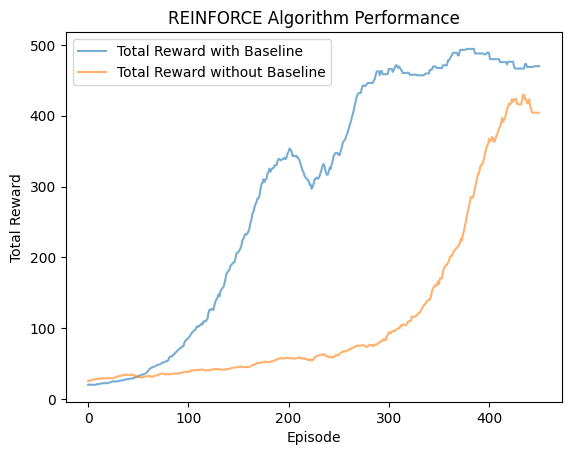

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50
smoothed_rewards_baseline = moving_average(total_rewards_baseline, window_size)
smoothed_rewards_without_baseline = moving_average(total_rewards_without_baseline, window_size)

plt.plot(smoothed_rewards_baseline, alpha=0.6, label='Total Reward with Baseline')
plt.plot(smoothed_rewards_without_baseline, alpha=0.6, label='Total Reward without Baseline')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE Algorithm Performance')
plt.legend()
plt.show()